In [106]:
import os
import pandas as pd
import numpy as np

In [107]:
def read_csvs_from_dir(root_dir):
    data = [] # list to save tuples (cell_num, numpy array)

    # walk through directory hierarchy
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if '_sample.csv' in filename: # check if file is a sample CSV
                cell_num = os.path.basename(dirpath) # extract cell number from folder name
                file_path = os.path.join(dirpath, filename) # get full file path
                df = pd.read_csv(file_path, usecols=[2]) # read only third column into dataframe
                np_arr = df.values.flatten() # convert dataframe to numpy array
                data.append((cell_num, np_arr)) # append tuple to list

    return data

root_dir = 'ConductivityData/Kv1.1/Temp_25C'
data = read_csvs_from_dir(root_dir)

# Print out first numpy array for testing
print(data[0][0]) # print cell number
print(data[0][1]) # print numpy array


21788
[-0.015589   -0.0015474   0.02590716 ...  0.74021032  0.73844532
  0.73707443]


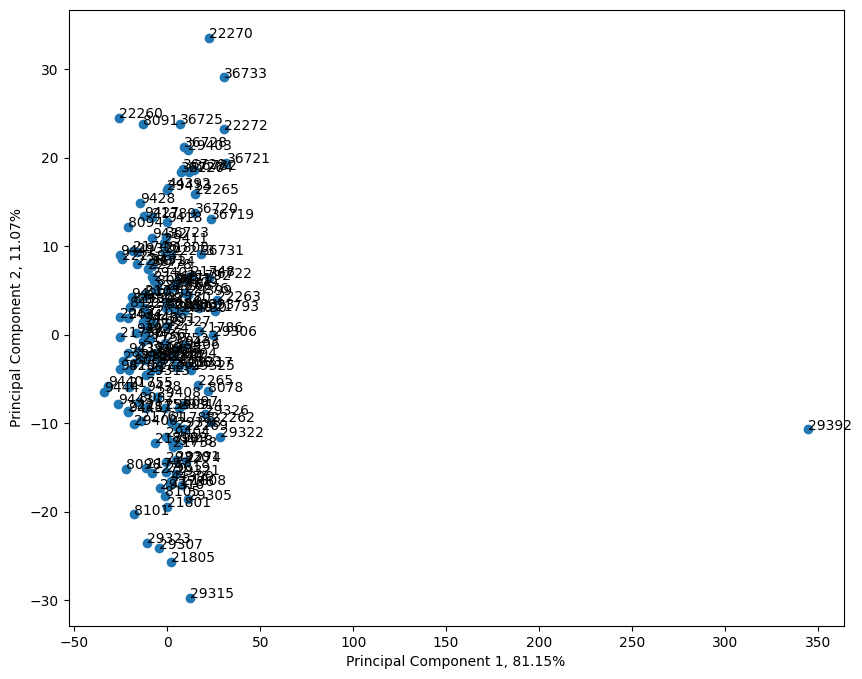

In [108]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Prepare data for PCA
# Convert list of tuples to list of arrays, and then to 2D numpy array
X = np.array([item[1] for item in data])

# Standardize the features to have mean=0 and variance=1
X = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Create a new dataframe with the first two principal components
principalDf = pd.DataFrame(data = X_pca[:,:2], columns = ['principal component 1', 'principal component 2'])

# Plot the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])

# Annotate each point with cell number
for i, item in enumerate(data):
    plt.annotate(item[0], (principalDf['principal component 1'].iloc[i], principalDf['principal component 2'].iloc[i]))

plt.xlabel(f'Principal Component 1, {pca.explained_variance_ratio_[0]*100:.2f}%')
plt.ylabel(f'Principal Component 2, {pca.explained_variance_ratio_[1]*100:.2f}%')
plt.show()


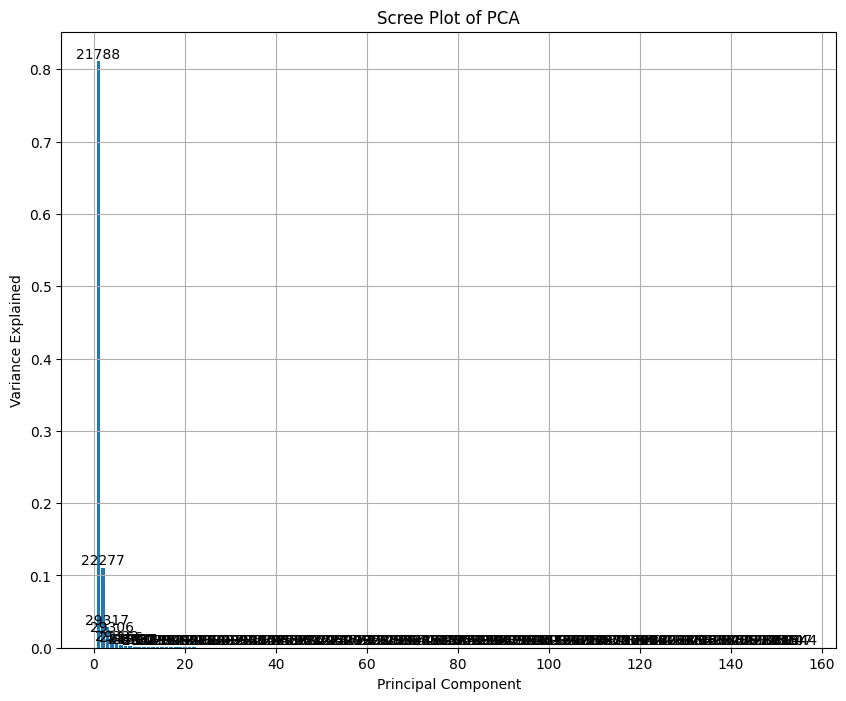

In [109]:
# Generate Scree plot
fig, ax = plt.subplots(figsize=(10,8))
bars = plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

# Label each bar with corresponding cell number
for bar, item in zip(bars, data):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), item[0], ha='center', va='bottom')

plt.title('Scree Plot of PCA')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually

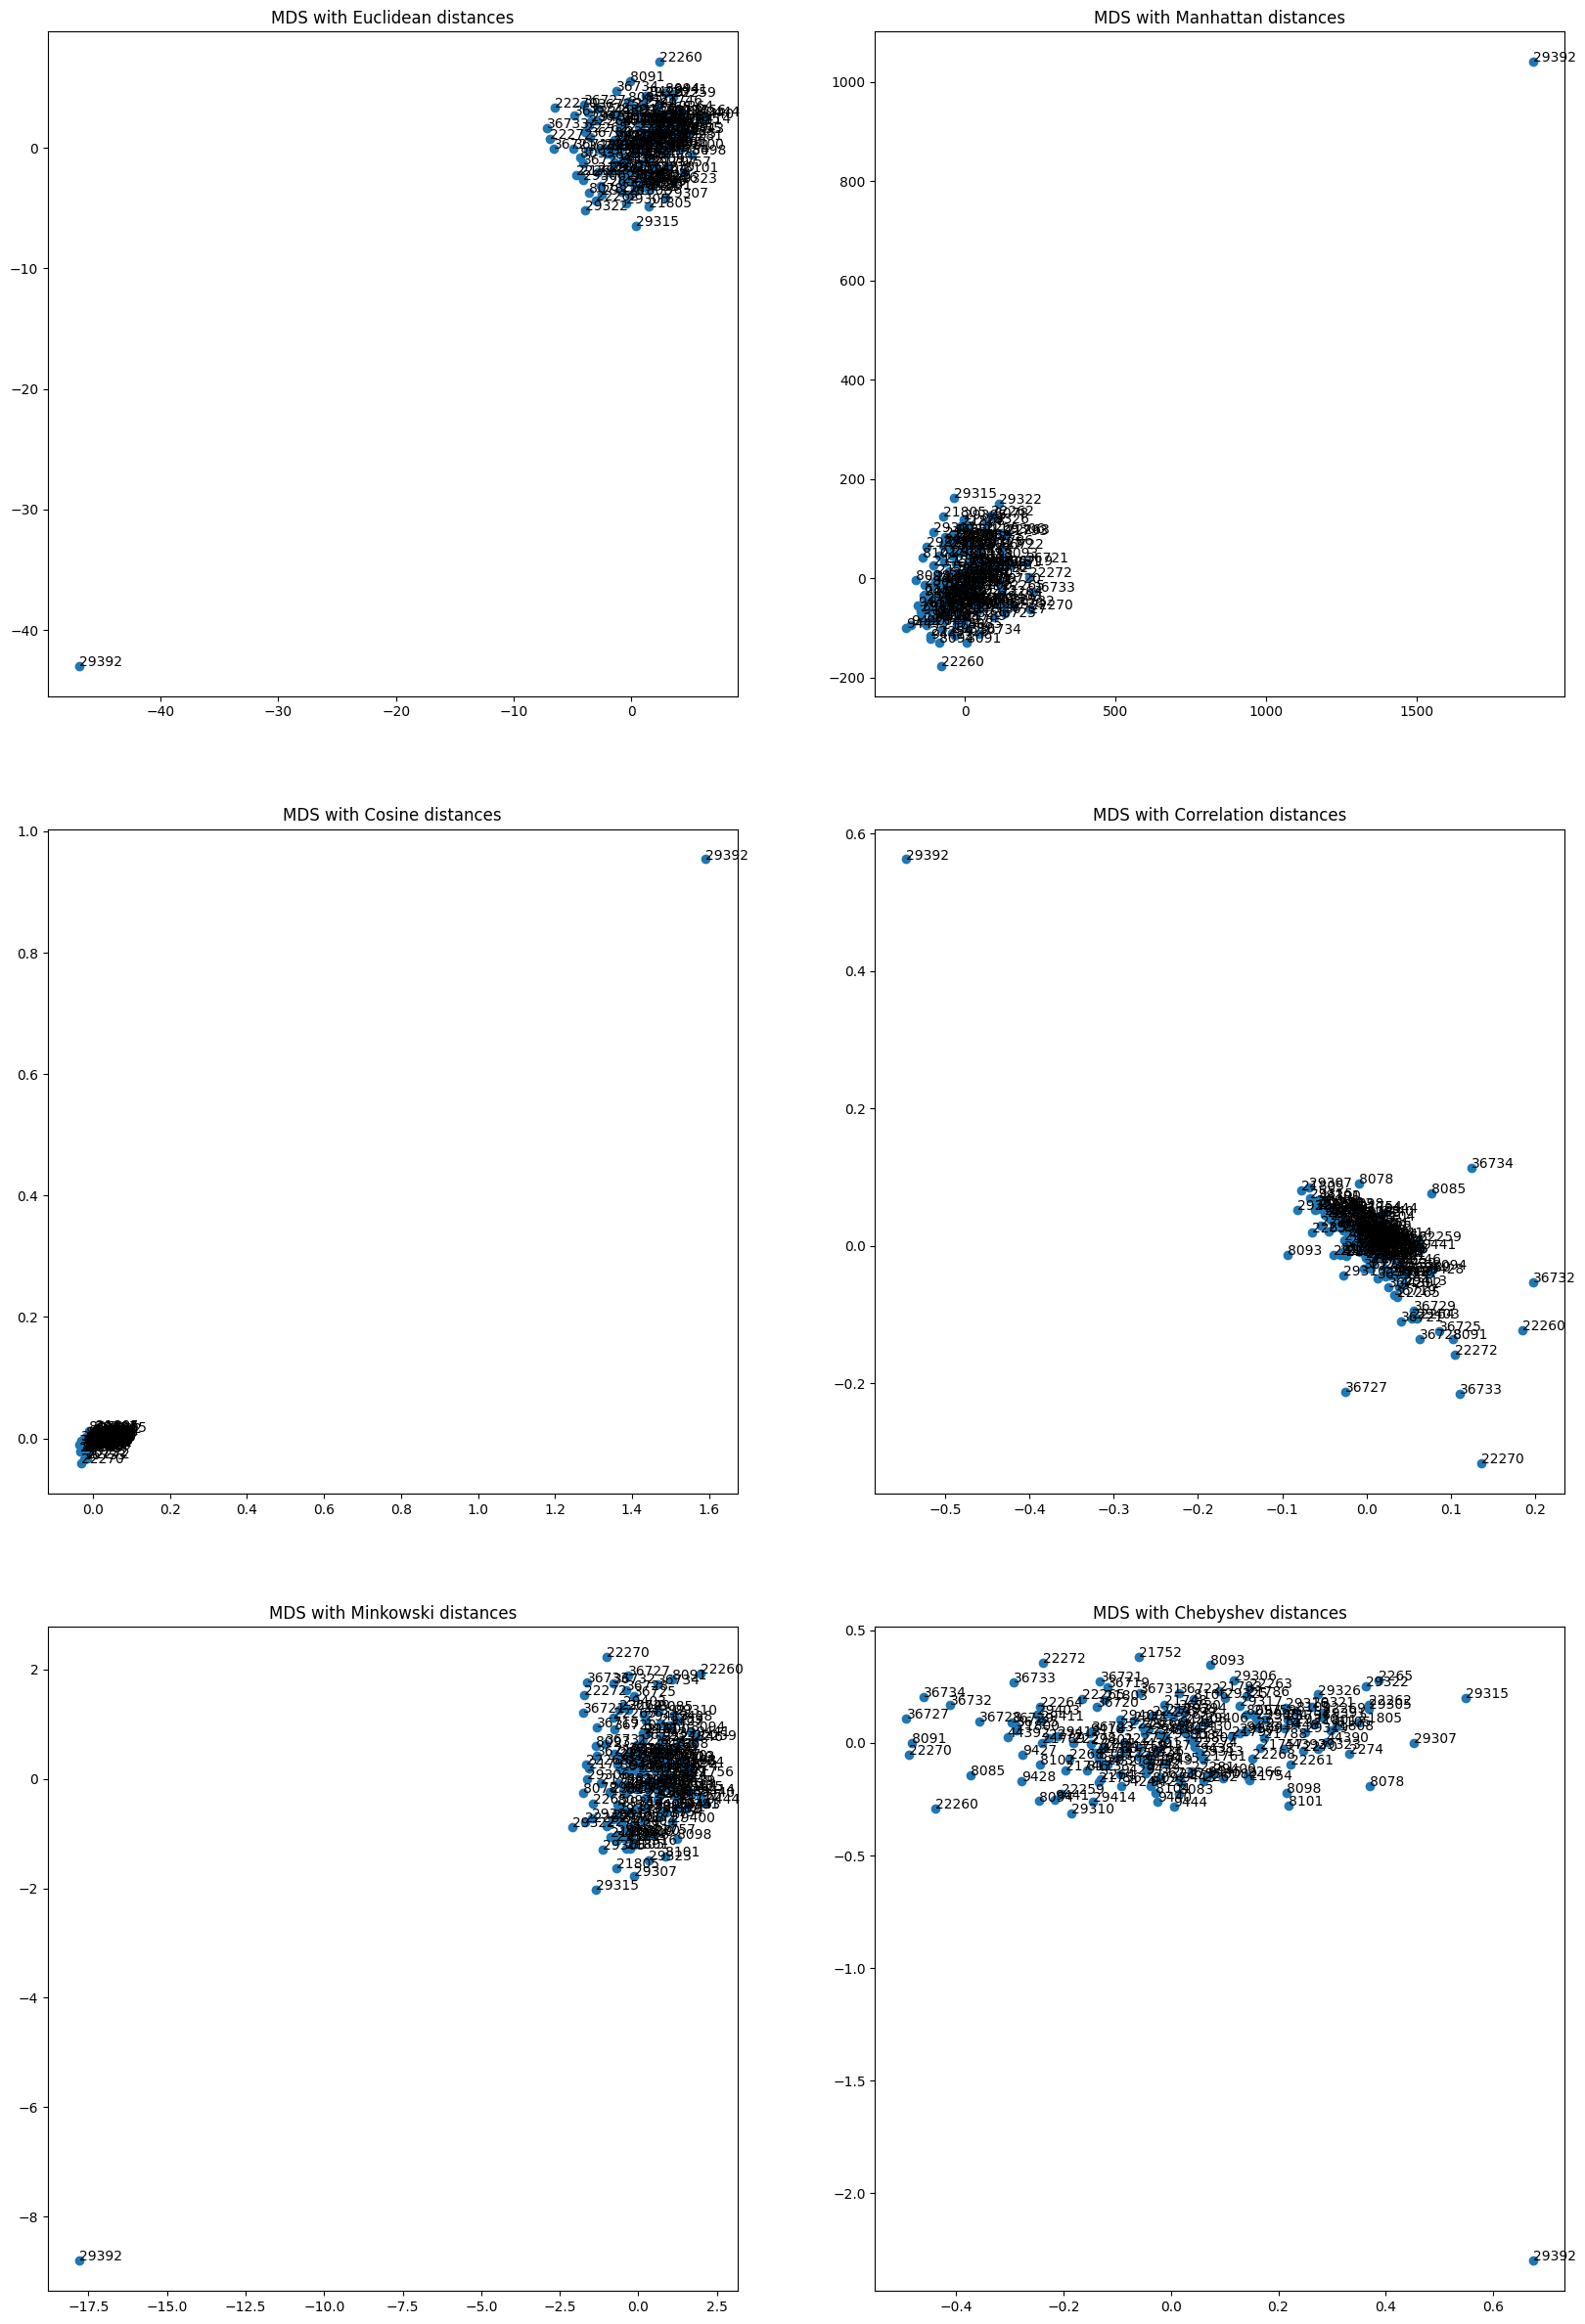

In [110]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from scipy.spatial.distance import minkowski, correlation, chebyshev
import numpy as np

# Helper function to compute a distance matrix given a distance function
def compute_distance_matrix(X, dist_func, **kwargs):
    n_samples = X.shape[0]
    dist_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            dist_matrix[i, j] = dist_func(X[i], X[j], **kwargs)
            dist_matrix[j, i] = dist_matrix[i, j]  # distance matrix is symmetric
    return dist_matrix

# Prepare data for MDS
X = np.array([item[1] for item in data])

# Compute distance matrices
dist_euclidean = euclidean_distances(X)
dist_cityblock = manhattan_distances(X)
dist_cosine = cosine_distances(X)
dist_correlation = compute_distance_matrix(X, correlation)
dist_minkowski = compute_distance_matrix(X, minkowski, p=3)  # p parameter defines the power for the Minkowski metric
dist_chebyshev = compute_distance_matrix(X, chebyshev)

# Apply MDS with different distances
mds_euclidean = MDS(n_components=2, dissimilarity='precomputed')
X_mds_euclidean = mds_euclidean.fit_transform(dist_euclidean)

mds_cityblock = MDS(n_components=2, dissimilarity='precomputed')
X_mds_cityblock = mds_cityblock.fit_transform(dist_cityblock)

mds_cosine = MDS(n_components=2, dissimilarity='precomputed')
X_mds_cosine = mds_cosine.fit_transform(dist_cosine)

mds_correlation = MDS(n_components=2, dissimilarity='precomputed')
X_mds_correlation = mds_correlation.fit_transform(dist_correlation)

mds_minkowski = MDS(n_components=2, dissimilarity='precomputed')
X_mds_minkowski = mds_minkowski.fit_transform(dist_minkowski)

mds_chebyshev = MDS(n_components=2, dissimilarity='precomputed')
X_mds_chebyshev = mds_chebyshev.fit_transform(dist_chebyshev)

# Create plots
fig, ax = plt.subplots(3, 2, figsize=(20, 30))

# Euclidean MDS plot
ax[0, 0].scatter(X_mds_euclidean[:, 0], X_mds_euclidean[:, 1])
for i, item in enumerate(data):
    ax[0, 0].annotate(item[0], (X_mds_euclidean[i, 0], X_mds_euclidean[i, 1]))
ax[0, 0].set_title('MDS with Euclidean distances')

# Manhattan MDS plot
ax[0, 1].scatter(X_mds_cityblock[:, 0], X_mds_cityblock[:, 1])
for i, item in enumerate(data):
    ax[0, 1].annotate(item[0], (X_mds_cityblock[i, 0], X_mds_cityblock[i, 1]))
ax[0, 1].set_title('MDS with Manhattan distances')

# Cosine MDS plot
ax[1, 0].scatter(X_mds_cosine[:, 0], X_mds_cosine[:, 1])
for i, item in enumerate(data):
    ax[1, 0].annotate(item[0], (X_mds_cosine[i, 0], X_mds_cosine[i, 1]))
ax[1, 0].set_title('MDS with Cosine distances')

# Correlation MDS plot
ax[1, 1].scatter(X_mds_correlation[:, 0], X_mds_correlation[:, 1])
for i, item in enumerate(data):
    ax[1, 1].annotate(item[0], (X_mds_correlation[i, 0], X_mds_correlation[i, 1]))
ax[1, 1].set_title('MDS with Correlation distances')

# Minkowski MDS plot
ax[2, 0].scatter(X_mds_minkowski[:, 0], X_mds_minkowski[:, 1])
for i, item in enumerate(data):
    ax[2, 0].annotate(item[0], (X_mds_minkowski[i, 0], X_mds_minkowski[i, 1]))
ax[2, 0].set_title('MDS with Minkowski distances')

# Chebyshev MDS plot
ax[2, 1].scatter(X_mds_chebyshev[:, 0], X_mds_chebyshev[:, 1])
for i, item in enumerate(data):
    ax[2, 1].annotate(item[0], (X_mds_chebyshev[i, 0], X_mds_chebyshev[i, 1]))
ax[2, 1].set_title('MDS with Chebyshev distances')

plt.show()


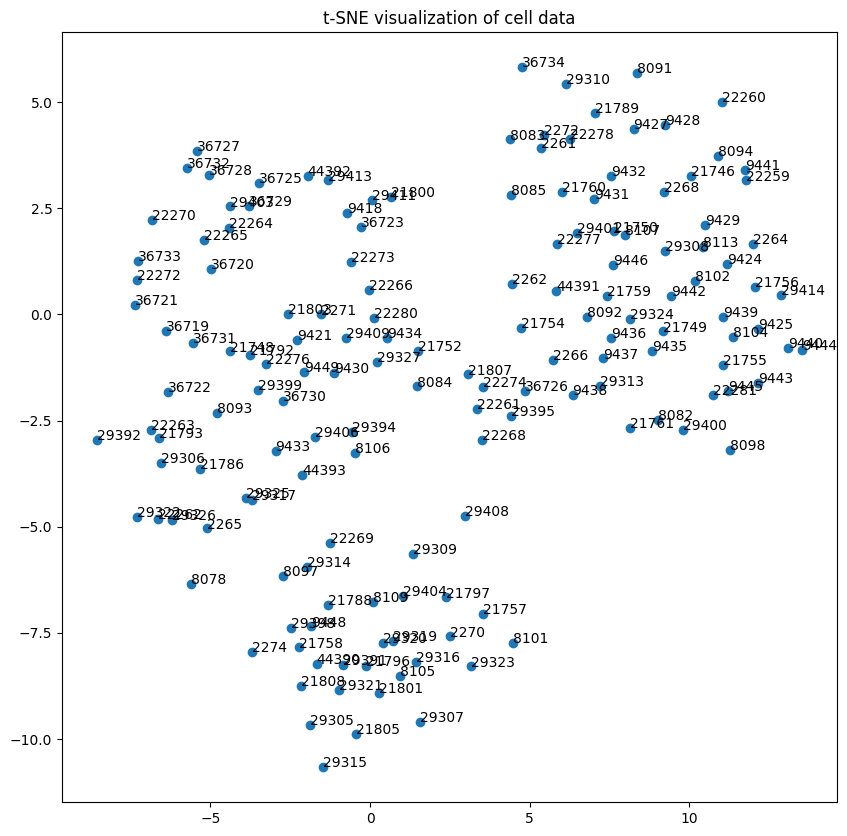

In [111]:
from sklearn.manifold import TSNE

# Use PCA for initial dimensionality reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Apply t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_pca)

# Create plot
plt.figure(figsize=(10, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
for i, item in enumerate(data):
    plt.annotate(item[0], (X_tsne[i, 0], X_tsne[i, 1]))
plt.title('t-SNE visualization of cell data')
plt.show()


In [112]:
import numpy as np

def calculate_change_rate_score(cell_data):
    # Calculate the slope between each pair of consecutive points
    slopes = np.diff(cell_data, axis=0) / np.diff(np.arange(len(cell_data)))

    # Calculate the absolute difference between the slopes of consecutive points
    slope_diffs = np.abs(np.diff(slopes, axis=0))

    # Return the average of these differences as the "change rate score"
    return np.mean(slope_diffs)

# Calculate change rate score for each cell and add it to the data
for i in range(len(data)):
    cell_num, cell_data = data[i]
    change_rate_score = calculate_change_rate_score(cell_data)
    data[i] = (cell_num, cell_data, change_rate_score)

# Sort cells by change rate score (lower = smoother)
data.sort(key=lambda x: x[2])

# Print out sorted data (cell numbers and their change rate scores)
for cell_num, cell_data, change_rate_score in data:
    print(f"Cell {cell_num}: Change Rate Score = {change_rate_score}")


Cell 21808: Change Rate Score = 0.02037817642722147
Cell 9433: Change Rate Score = 0.020391431172836833
Cell 21793: Change Rate Score = 0.020584016928655226
Cell 9448: Change Rate Score = 0.020584280018547334
Cell 29322: Change Rate Score = 0.02083027542482605
Cell 21805: Change Rate Score = 0.021093038299148815
Cell 8097: Change Rate Score = 0.021172153975148288
Cell 29398: Change Rate Score = 0.021317684437824877
Cell 21796: Change Rate Score = 0.02157495166817673
Cell 21758: Change Rate Score = 0.02163685638955786
Cell 22262: Change Rate Score = 0.021976137502281685
Cell 9421: Change Rate Score = 0.022370436604765193
Cell 44390: Change Rate Score = 0.022741429203664607
Cell 9449: Change Rate Score = 0.02282498391987756
Cell 36721: Change Rate Score = 0.022914081005145824
Cell 29399: Change Rate Score = 0.023091509112307826
Cell 9430: Change Rate Score = 0.023149162124952393
Cell 21788: Change Rate Score = 0.02319299367754095
Cell 21807: Change Rate Score = 0.02335791537432371
Cell 2

In [113]:
import numpy as np

def calculate_outlier_score(cell_data):
    # Calculate IQR
    Q1 = np.percentile(cell_data, 25)
    Q3 = np.percentile(cell_data, 75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count number of outliers
    outlier_count = np.sum((cell_data < lower_bound) | (cell_data > upper_bound))

    # Return ratio of outliers to total measurements
    return outlier_count / len(cell_data)

# Calculate outlier score for each cell and add it to the data
for i in range(len(data)):
    cell_num, cell_data = data[i]
    outlier_score = calculate_outlier_score(cell_data)
    data[i] = (cell_num, cell_data, outlier_score)

# Sort cells by outlier score (lower = fewer outliers)
data.sort(key=lambda x: x[2])

# Print out sorted data (cell numbers and their outlier scores)
for cell_num, cell_data, outlier_score in data:
    print(f"Cell {cell_num}: Outlier Score = {outlier_score}")

ValueError: too many values to unpack (expected 2)

In [ ]:
def calculate_smoothness_score(cell_data):
    # Calculate differences between consecutive measurements
    differences = np.diff(cell_data)
    # Return standard deviation of differences
    return np.std(differences)

# Calculate smoothness score for each cell and add it to the data
for i in range(len(data)):
    cell_num, cell_data = data[i]
    smoothness_score = calculate_smoothness_score(cell_data)
    data[i] = (cell_num, cell_data, smoothness_score)

# Sort cells by smoothness score (lower = smoother)
data.sort(key=lambda x: x[2])

# Print out sorted data (cell numbers and their smoothness scores)
for cell_num, cell_data, smoothness_score in data:
    print(f"Cell {cell_num}: Smoothness Score = {smoothness_score}")


ValueError: too many values to unpack (expected 2)

ValueError: too many values to unpack (expected 2)